# 📂 Capítulo 4 - Técnicas de Validación

La validación de modelos de **detección de anomalías en series temporales** plantea retos adicionales frente a la validación en datos convencionales. La razón principal es la **naturaleza temporal de las señales**, que introduce dependencias y restricciones que impiden aplicar directamente técnicas clásicas como la *Cross-Validation aleatoria* o el *Bootstrap*.  

En problemas tradicionales, las observaciones suelen considerarse independientes e intercambiables. En cambio, en series temporales:

- ⏱️ **Dependencia temporal** → lo que ocurre en el instante \(t\) depende de lo que ocurrió en \(t-1\).  
- ⚠️ **Riesgo de fuga de información (*data leakage*)** → si se entrena un modelo con observaciones futuras y se valida en el pasado, los resultados carecen de validez práctica.  
- 📉 **Escasez y desbalance** → las anomalías son poco frecuentes en comparación con el comportamiento normal.  
- 📏 **Naturaleza de las anomalías** → a menudo se presentan como **intervalos** prolongados, no solo como puntos aislados.  

---

## 🎯 Objetivos de la validación temporal

En consecuencia, la validación en series temporales exige:

1. **Métricas específicas**, que midan no solo la detección puntual, sino también la cobertura de intervalos y, especialmente, la utilidad práctica de las detecciones tempranas.  
2. **Protocolos de validación temporales**, que respeten el orden cronológico de los datos y eviten cualquier mezcla entre pasado y futuro.  

---

## 📌 Estructura de este capítulo

A lo largo de este capítulo se presentan:  

- El enfoque **NAB (Numenta Anomaly Benchmark)** como referencia principal para **definir métricas de evaluación**, ya que:  
  - Premia detecciones tempranas dentro de una ventana de anomalía.  
  - Penaliza detecciones falsas fuera de las ventanas.  
  - Ofrece una función de puntuación continua y perfiles de aplicación para distintos escenarios de uso.  

- Como complemento, se introduce también el enfoque de **Range-Based Validation**, que extiende la evaluación a anomalías representadas como intervalos de distinta duración, unificando métricas clásicas con escenarios más generales.  

- Dos estrategias fundamentales para la **validación temporal de modelos**:  
  - **TSCV con ventanas rodantes (*Rolling Window*)**, aplicable a modelos que no permiten reentrenamiento incremental.  
  - **Rolling-Origin Evaluation**, adecuada para modelos capaces de actualizarse de manera progresiva.  

Con esta combinación de métricas y protocolos, se construye un marco sólido y realista para comparar el rendimiento de distintos detectores de anomalías en series temporales.

---

## 4.1 Enfoques para la definición de métricas

### 4.1.1 Numenta Anomaly Benchmark (NAB)

El benchmark **NAB (Numenta Anomaly Benchmark)** se ha convertido en un estándar de referencia en la evaluación de modelos de detección de anomalías en series temporales. Su principal aportación consiste en definir un sistema de **puntuación dinámico** que refleja de manera más realista el valor práctico de las detecciones en entornos reales.

El planteamiento surge de la siguiente observación: en la mayoría de los escenarios de uso (por ejemplo, mantenimiento predictivo, detección de fraudes o ciberseguridad) **no basta con detectar una anomalía, también importa cuándo se detecta**. Detectar justo al inicio de un fallo es útil, pero hacerlo **antes** es aún más valioso, ya que permite actuar preventivamente. En contraste, detectar demasiado tarde, o peor aún, generar falsas alarmas, reduce drásticamente la utilidad del sistema.

---

#### Principios del NAB
1. **Premio a las detecciones tempranas**  
   - Cuanto antes se emita la alarma dentro de la ventana de anomalía, mayor será la puntuación asignada.  
   - Si la detección ocurre justo al inicio de la ventana, el sistema obtiene la máxima recompensa.  

2. **Penalización de las falsas alarmas**  
   - Si el sistema señala anomalías fuera de las ventanas definidas como anómalas, recibe una penalización negativa.  
   - Esto evita que un detector logre un recall artificialmente alto generando continuas falsas alarmas.  

3. **Función de puntuación continua**  
   - La evaluación no se limita a etiquetar como “correcta/incorrecta” una detección, sino que define una función suave que decrece conforme la detección se aleja del inicio de la ventana.  
   - Esto permite medir el grado de **tempraneidad** o **retraso** en la detección.  

---

#### Fórmula de la puntuación

Sea una anomalía anotada $i$ con ventana $W_i = [t_{i,\text{start}}, t_{i,\text{end}}]$.  
Si el detector emite una alarma en $t$ dentro de esa ventana, su contribución se calcula mediante una **función sigmoide decreciente de recompensa**:

$$
s(t) = A_{TP} \cdot \frac{2}{1 + e^{k \cdot \frac{t - t_{i,\text{start}}}{|W_i|}}}, \quad k > 0
$$

- Detecciones al inicio ($t \approx t_{i,\text{start}}$) $\;\Rightarrow\;$ $s(t) \approx A_{TP}$ (máxima recompensa).  
- Detecciones tardías ($t \to t_{i,\text{end}}$) $\;\Rightarrow\;$ la puntuación decrece suavemente hacia 0.  

Los **falsos positivos** (detecciones fuera de toda ventana) se penalizan con:

$$
s_{\mathrm{FP}} = - A_{FP}
$$

Y si no hay ninguna detección en la ventana (falso negativo):

$$
s_{\mathrm{FN}} = - A_{FN}
$$

donde $A_{TP}, A_{FP}, A_{FN}$ son constantes que dependen del *perfil de aplicación* elegido (por ejemplo, `standard`, `reward low FP`, `reward low FN`).

---

#### Normalización

La puntuación total bruta se obtiene como:

$$
S_{\text{raw}} = \sum_i s_i
$$

y después se **normaliza** en el rango $[0, 100]$ comparando con dos detectores de referencia:

$$
S_{\text{norm}} = 100 \times \frac{S_{\text{raw}} - S_{\text{null}}}{S_{\text{perfect}} - S_{\text{null}}}
$$

- $S_{\text{perfect}}$: detector ideal (detecta todas las anomalías al inicio, sin FP).  
- $S_{\text{null}}$: detector nulo (no detecta nada).  

De este modo, un modelo perfecto alcanza 100 puntos y uno nulo queda en 0, mientras que cualquier algoritmo real queda escalado en ese intervalo.

---





#### Ejemplo ilustrativo con Python

A continuación, un pequeño ejemplo para entender cómo funciona este sistema. Creamos una serie temporal con un intervalo de anomalía y simulamos distintas detecciones para ver cómo se calcula el puntaje de acuerdo al NAB:

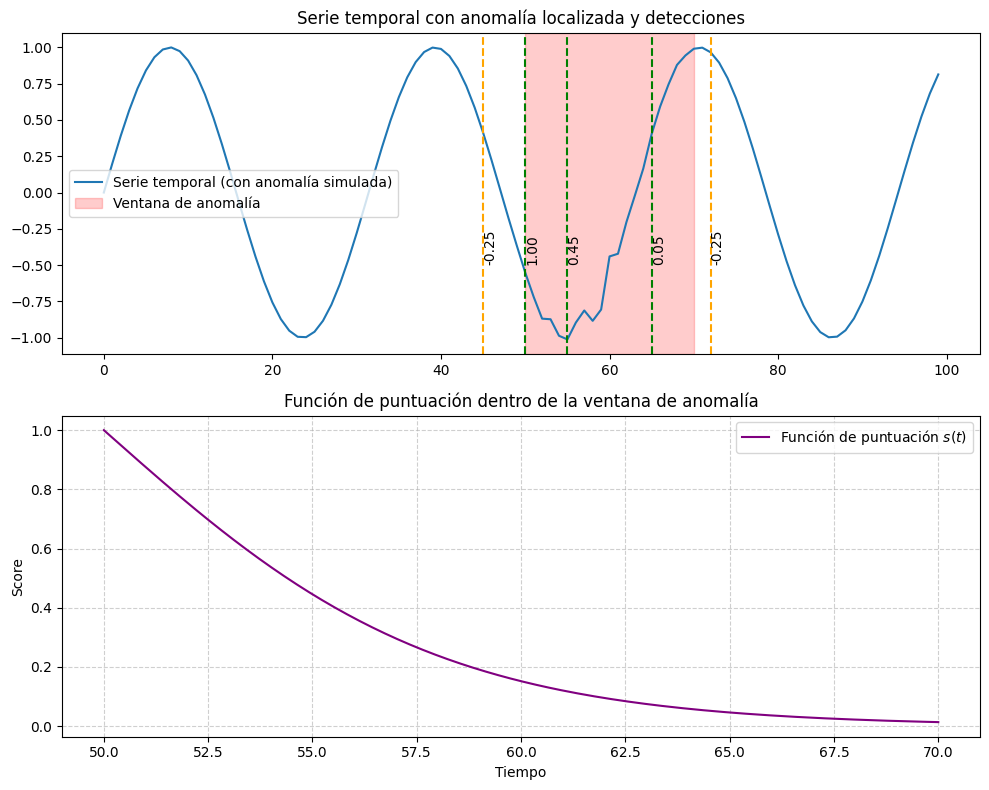

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Definimos una ventana de anomalía entre t=50 y t=70
anomaly_start, anomaly_end = 50, 70

# Parámetros de aplicación
A_TP = 1.0   # recompensa máxima por detección temprana
A_FP = 0.25   # penalización por falso positivo
k = 5       # pendiente de la sigmoide

# Fórmula del .md (sigmoide decreciente de recompensa)
def nab_score(detection, start, end, A_TP=1.0, A_FP=0.5, k=10):
    if start <= detection <= end:
        x = (detection - start) / (end - start)  # normalización [0,1]
        score = A_TP * (1 / (1 + np.exp(k * x))) * 2
        return score
    else:
        return -A_FP

# Simulamos detecciones
detections = [45, 50, 55, 65, 72]
scores = [nab_score(d, anomaly_start, anomaly_end, A_TP, A_FP, k) for d in detections]

# Serie temporal con anomalía
time = np.arange(0, 100)
series = np.sin(time/5)

window_length = anomaly_end - anomaly_start
noise = np.random.normal(0, 0.1, window_length)
gaussian_mask = np.exp(-0.5 * ((np.linspace(-2, 2, window_length))**2))  
series[anomaly_start:anomaly_end] += noise * gaussian_mask

# Figura
fig, axes = plt.subplots(2, 1, figsize=(10,8))

# --- Subplot 1 ---
axes[0].plot(time, series, label="Serie temporal (con anomalía simulada)")
axes[0].axvspan(anomaly_start, anomaly_end, color="red", alpha=0.2, label="Ventana de anomalía")

for d, s in zip(detections, scores):
    axes[0].axvline(d, color="green" if s > 0 else "orange", linestyle="--")
    # Colocar la etiqueta encima del valor de la serie
    y_pos = -0.5
    axes[0].text(d, y_pos, f"{s:.2f}", rotation=90, va="bottom")

axes[0].legend()
axes[0].set_title("Serie temporal con anomalía localizada y detecciones")

# --- Subplot 2 ---
t_vals = np.linspace(anomaly_start, anomaly_end, 200)
s_vals = [nab_score(t, anomaly_start, anomaly_end, A_TP, A_FP, k) for t in t_vals]

axes[1].plot(t_vals, s_vals, color="purple", label="Función de puntuación $s(t)$")
axes[1].set_title("Función de puntuación dentro de la ventana de anomalía")
axes[1].set_xlabel("Tiempo")
axes[1].set_ylabel("Score")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()




## 4.2 Estrategias de validación de modelos

Además de definir métricas, es imprescindible diseñar un **protocolo de validación** coherente con el tipo de modelo, la dinámica temporal y el flujo de entrenamiento/serving. A continuación se detallan enfoques recomendados para **detección de anomalías en series temporales**, con atención especial a evitar fuga de información (*data leakage*) y a evaluar la utilidad práctica (p. ej., con NAB).

---

### 4.2.1 Time Series Cross-Validation (TSCV) con *Rolling Window*

**Cuándo usarlo**  
- Modelos que **no admiten reentrenamiento incremental** (p. ej., Isolation Forest, One-Class SVM, Autoencoders sin *fine-tuning* por streaming).  
- Entornos con **deriva de concepto**, donde conviene acotar el “pasado” que el modelo ve en cada evaluación.  
- Estimar rendimiento **deslizándose en el tiempo**, con conjuntos de entrenamiento de tamaño fijo y **ventanas rodantes**.

---

#### Notación y particionado

Sea una serie indexada por tiempo $\{(x_t, y_t)\}_{t=1}^T$ (en no supervisado, $y_t$ solo se usa para evaluación). Definimos:

- $L_{\text{train}}$: longitud de la ventana de **entrenamiento**.  
- $L_{\text{val}}$: longitud de la ventana de **validación**.  
- $G$: **gap/embargo** entre entrenamiento y validación para purgar dependencias.  
- $S$: **desplazamiento** (*step*) entre splits consecutivos.  

Para el split $j = 0, 1, \dots, J$:

$$
\mathcal{I}^{(j)}_{\text{train}} = [\, t_j - L_{\text{train}} + 1,\; t_j \,]
$$

$$
\mathcal{I}^{(j)}_{\text{gap}} = [\, t_j + 1,\; t_j + G \,]
$$

$$
\mathcal{I}^{(j)}_{\text{val}} = [\, t_j + G + 1,\; t_j + G + L_{\text{val}} \,]
$$

Con $t_{j+1} = t_j + S$ y número de splits:

$$
J + 1 = \left\lfloor \frac{T - L_{\text{train}} - G - L_{\text{val}}}{S} \right\rfloor + 1
$$

---

#### Regla de oro: sin fuga de información

- Toda transformación se **ajusta** (*fit*) solo en $\mathcal{I}^{(j)}_{\text{train}}$ y se **aplica** (*transform*) a $\mathcal{I}^{(j)}_{\text{val}}$.  
- Esto incluye: imputación, *scaling*, generación de *lags*/ventanas, PCA, selección de variables, calibración de umbrales, etc.

---

#### Elección práctica de $L_{\text{train}}, L_{\text{val}}, G, S$

- $L_{\text{train}}$: cubrir al menos **una estacionalidad completa** (habitual: 1–3 ciclos).  
- $L_{\text{val}}$: suficientemente largo para **observar anomalías** (recomendable ≥ 1 ciclo).  
- $G$: purgar dependencias inducidas por *lags*/suavizado y por anomalías detectadas.  
  - Regla práctica:
    $$
    G \ge \max\{\text{máx. lag en features},\ \text{longitud de suavizado},\ \tfrac{1}{2}\,|W_i|\}
    $$
- $S$: controla la **resolución** de la evaluación.  
  - $S = L_{\text{val}}$: splits no solapados.  
  - $S < L_{\text{val}}$: validaciones solapadas → más muestras, más redundancia.

---

### 4.2.2 Rolling-Origin Evaluation con Reentrenamiento
Se emplea cuando el modelo **sí permite reentrenamiento incremental**.  

- El proceso comienza con un **bloque inicial de entrenamiento sin anomalías**.  
- La validación se realiza sobre bloques sucesivos. Una vez detectadas las anomalías, estas se **eliminan o marcan como outliers** en los datos.  
- Los bloques validados y “limpios” se incorporan al conjunto de entrenamiento, ampliando progresivamente la base de conocimiento del modelo.  

---

## 4.3 Consideraciones sobre la limpieza de anomalías
Para mantener la robustez del proceso, es fundamental aplicar una estrategia de **limpieza de anomalías detectadas** en los bloques de validación antes de incorporarlos al entrenamiento.  

Esto evita que el modelo aprenda patrones espurios asociados a las anomalías y permite una evaluación más realista de su capacidad de generalización.  

---

## 4.4 Resumen
En síntesis:  
- Se adoptan métricas combinadas de **punto e intervalo**, integrando ideas de NAB y Range-Based Validation.  
- El proceso de validación depende del tipo de modelo:  
  - **Rolling Window** para modelos sin reentrenamiento incremental.  
  - **Rolling-Origin Evaluation** para modelos que sí lo permiten, incorporando mecanismos de limpieza de anomalías.  

De este modo, se logra un marco de validación coherente y adaptado a las particularidades de la detección de anomalías en series temporales.